In [1]:
import pandas as pd
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import Ridge, LinearRegression
from sklearn import metrics

In [92]:
df_submission = pd.read_csv('/content/sample_submission.csv')
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_weather = pd.read_csv('/content/weather.csv')

In [117]:
X_train = X_train[['log_distance', 'max_temp', 'min_temp', 'average_temp', 'prec',
       'snow_fall', 'snow_depth', 'passenger_1', 'passenger_2', 'passenger_3',
       'passenger_4', 'passenger_5', 'passenger_6', 'passenger_7',
       'passenger_8', 'passenger_9', 'vendor_2', 'flag_Y', 'February',
       'January', 'June', 'March', 'May', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23']]

In [118]:
X_train.columns

Index(['log_distance', 'max_temp', 'min_temp', 'average_temp', 'prec',
       'snow_fall', 'snow_depth', 'passenger_1', 'passenger_2', 'passenger_3',
       'passenger_4', 'passenger_5', 'passenger_6', 'passenger_7',
       'passenger_8', 'passenger_9', 'vendor_2', 'flag_Y', 'February',
       'January', 'June', 'March', 'May', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '20', '21', '22', '23'],
      dtype='object')

#### Shared Functions

In [72]:
def haversine(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    R = 6371.0

    pickup_lat = math.radians(pickup_lat)
    pickup_long = math.radians(pickup_long)
    dropoff_lat = math.radians(dropoff_lat)
    dropoff_long = math.radians(dropoff_long)

    dlon = dropoff_long - pickup_long
    dlat = dropoff_lat - pickup_lat

    # Формула Haversine
    a = math.sin(dlat / 2)**2 + math.cos(pickup_lat) * math.cos(dropoff_lat) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Расстояние между двумя точками
    distance = R * c

    return distance

#### Preparation df_train

In [93]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])
# df_train = df_train.drop(df_train[df_train['trip_duration'] > 5000].index)
# df_train = df_train.drop(df_train[df_train['trip_duration'] < 60].index)

dates_to_drop = ['2016-01-23', '2016-01-24', '2016-01-25', '2016-05-30']
dates_to_drop = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates_to_drop]
df_train = df_train[~df_train['pickup_datetime'].dt.floor('D').isin(dates_to_drop)]

s_distance = df_train.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df_info_trip = pd.DataFrame({
    'log_distance' : np.log1p(s_distance),
    'distance' : s_distance,
    'time_trip_in_hour' : (df_train['dropoff_datetime'] - df_train['pickup_datetime']).dt.total_seconds() / 3600,
    'mean_speed' : s_distance / ((df_train['dropoff_datetime'] - df_train['pickup_datetime']).dt.total_seconds() / 3600),
})

df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'])
df_train = pd.concat([df_train, df_info_trip], axis=1)

# df_train = df_train.drop(df_train[df_train['mean_speed'] > 100].index)
# df_train = df_train.drop(df_train[df_train['mean_speed'] < 1].index)
# df_train = df_train.drop(df_train[df_train['distance'] < 0.07].index)

In [94]:
df_train = df_train.rename(columns={'pickup_longitude': 'up_long', 'pickup_latitude': 'up_lat', 'dropoff_longitude': 'drop_long', 'dropoff_latitude': 'drop_lat'})

#### Preparation df_test

In [95]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [96]:
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
s_distance = df_test.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df_test['log_distance'] = np.log1p(s_distance)

#### Preparation df_weather

In [97]:
df_weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [98]:
df_weather = df_weather.rename({'date':'datetime', 'maximum temperature': 'max_temp', 'minimum temperature': 'min_temp', 'average temperature': 'average_temp', 'precipitation': 'prec', 'snow fall': 'snow_fall', 'snow depth': 'snow_depth'}, axis=1)
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], dayfirst=True)
df_weather['prec'] = df_weather['prec'].replace('T', 0)
df_weather['snow_fall'] = df_weather['snow_fall'].replace('T', 0)
df_weather['snow_depth'] = df_weather['snow_depth'].replace('T', 0)

In [99]:
df_train['pickup_date'] = pd.to_datetime(df_train['pickup_datetime'].dt.date)
df_train = pd.merge(df_train, df_weather, left_on='pickup_date', right_on='datetime', how='left')
df_train.drop(['pickup_date', 'datetime'], axis=1, inplace=True)

df_test['pickup_date'] = pd.to_datetime(df_test['pickup_datetime'].dt.date)
df_test = pd.merge(df_test, df_weather, left_on='pickup_date', right_on='datetime', how='left')
df_test.drop(['pickup_date', 'datetime'], axis=1, inplace=True)

#### Encode df_train
```
return X_train, y_train
```


In [100]:
# encode flag
df_store_encoded = pd.get_dummies(df_train['store_and_fwd_flag'], prefix='flag', drop_first=True)

# encode vendor_id
df_vendor_encoded = pd.get_dummies(df_train['vendor_id'], prefix='vendor', drop_first=True)

# encode passenger_count
df_passenger_count = pd.get_dummies(df_train['passenger_count'], prefix='passenger', drop_first=True)

# encode month
df_train['month'] = df_train['pickup_datetime'].dt.month_name()
df_month_encoded = pd.get_dummies(df_train['month'], drop_first=True)

# encode day of week
df_train['day_of_week'] = df_train['pickup_datetime'].dt.day_name()
df_day_of_week_encoded = pd.get_dummies(df_train['day_of_week'], drop_first=True)

# encode hour of day
df_train['hour_of_day'] = df_train['pickup_datetime'].dt.hour
df_hour_of_day_encoded = pd.get_dummies(df_train['hour_of_day'], drop_first=True)

# drop rest
df_train.drop(['day_of_week', 'store_and_fwd_flag', 'month', 'hour_of_day', 'vendor_id', 'passenger_count'], axis=1, inplace=True)

# concat
df_train = pd.concat([df_train, df_passenger_count, df_vendor_encoded, df_store_encoded, df_month_encoded, df_day_of_week_encoded, df_hour_of_day_encoded], axis=1)

In [101]:
X_train = df_train.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'up_long', 'up_lat', 'drop_long', 'drop_lat', 'trip_duration', 'log_trip_duration', 'distance', 'time_trip_in_hour', 'mean_speed'], axis=1)
y_train = df_train['log_trip_duration']
X_train.columns = X_train.columns.astype(str)

In [103]:
# X_train.insert(12, 'passenger_9', 0)
X_train = X_train.rename({'passenger_6': 'passenger_9', 'passenger_9': 'passenger_6'}, axis=1)

In [ ]:
X_train.head()

#### Encode df_test
```
return X_test
```

In [104]:
df_test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_distance', 'max_temp',
       'min_temp', 'average_temp', 'prec', 'snow_fall', 'snow_depth'],
      dtype='object')

In [105]:
# encode flag
df_store_encoded = pd.get_dummies(df_test['store_and_fwd_flag'], prefix='flag', drop_first=True)

# encode vendor_id
df_vendor_encoded = pd.get_dummies(df_test['vendor_id'], prefix='vendor', drop_first=True)

# encode passenger_count
df_passenger_count = pd.get_dummies(df_test['passenger_count'], prefix='passenger', drop_first=True)

# encode month
df_test['month'] = df_test['pickup_datetime'].dt.month_name()
df_month_encoded = pd.get_dummies(df_test['month'], drop_first=True)

# encode day of week
df_test['day_of_week'] = df_test['pickup_datetime'].dt.day_name()
df_day_of_week_encoded = pd.get_dummies(df_test['day_of_week'], drop_first=True)

# encode hour of day
df_test['hour_of_day'] = df_test['pickup_datetime'].dt.hour
df_hour_of_day_encoded = pd.get_dummies(df_test['hour_of_day'], drop_first=True)

# drop rest
df_test.drop(['day_of_week', 'store_and_fwd_flag', 'month', 'hour_of_day', 'vendor_id', 'passenger_count'], axis=1, inplace=True)

# concat
df_test = pd.concat([df_test, df_passenger_count, df_vendor_encoded, df_store_encoded, df_month_encoded, df_day_of_week_encoded, df_hour_of_day_encoded], axis=1)

In [106]:
X_test = df_test.drop(['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1)
X_test.columns = X_test.columns.astype(str)

#### Fit model Ridge
---
RMSLE on training data: 0.416 \\
RMSLE on testing data: 0.726


In [124]:
y_test = np.log1p(df_submission['trip_duration'])

In [125]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)
y_train_pred = model_ridge.predict(X_train)
y_test_pred = model_ridge.predict(X_test)

In [126]:
print(
    'RMSLE on training data:',
    round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 3)
)
print(
    'RMSLE on testing data:',
    round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 3)
)

RMSLE on training data: 0.499
RMSLE on testing data: 0.747


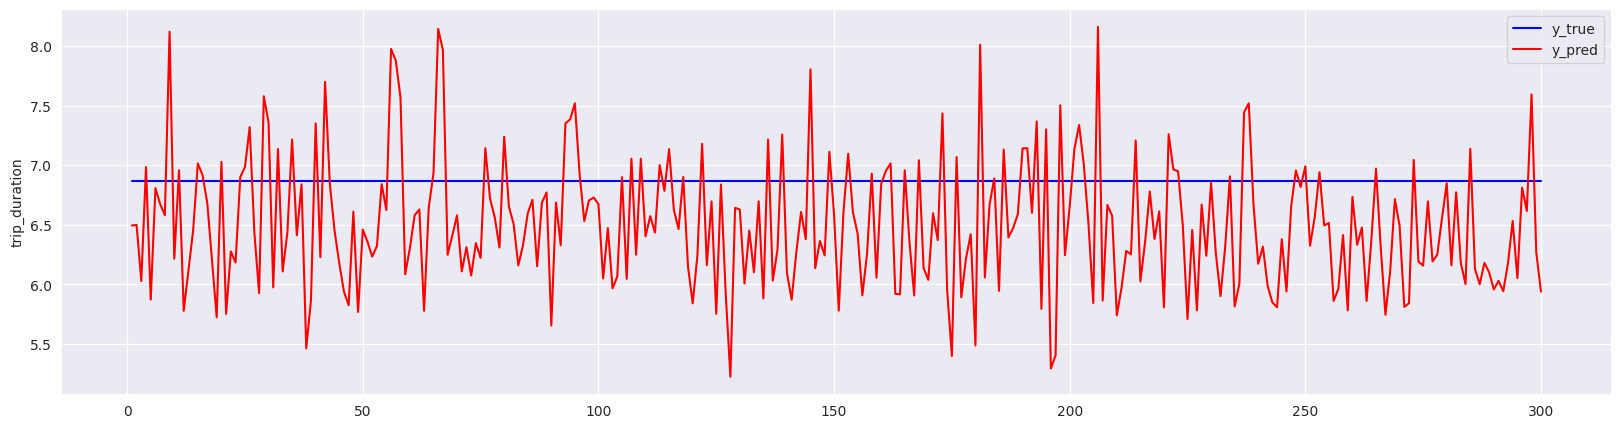

In [91]:
y_test_for_plot = y_test[:300]
y_test_pred_for_plot = y_test_pred[:300]
n = len(y_test_for_plot)

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x=np.linspace(1, n, n), y=y_test_for_plot, color='b', label='y_true')
ax = sns.lineplot(x=np.linspace(1, n, n), y=y_test_pred_for_plot, color='r', label='y_pred')

#### Fit model Linear
---
RMSLE on training data: 0.416 \\
RMSLE on testing data: 12717.742

In [ ]:
y_test = np.log1p(df_submission['trip_duration'])

In [ ]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_train_pred = model_linear.predict(X_train)
y_test_pred = model_linear.predict(X_test)

In [ ]:
print(
    'RMSLE on training data:',
    round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 3)
)
print(
    'RMSLE on testing data:',
    round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 3)
)

RMSLE on training data: 0.416
RMSLE on testing data: 12717.742


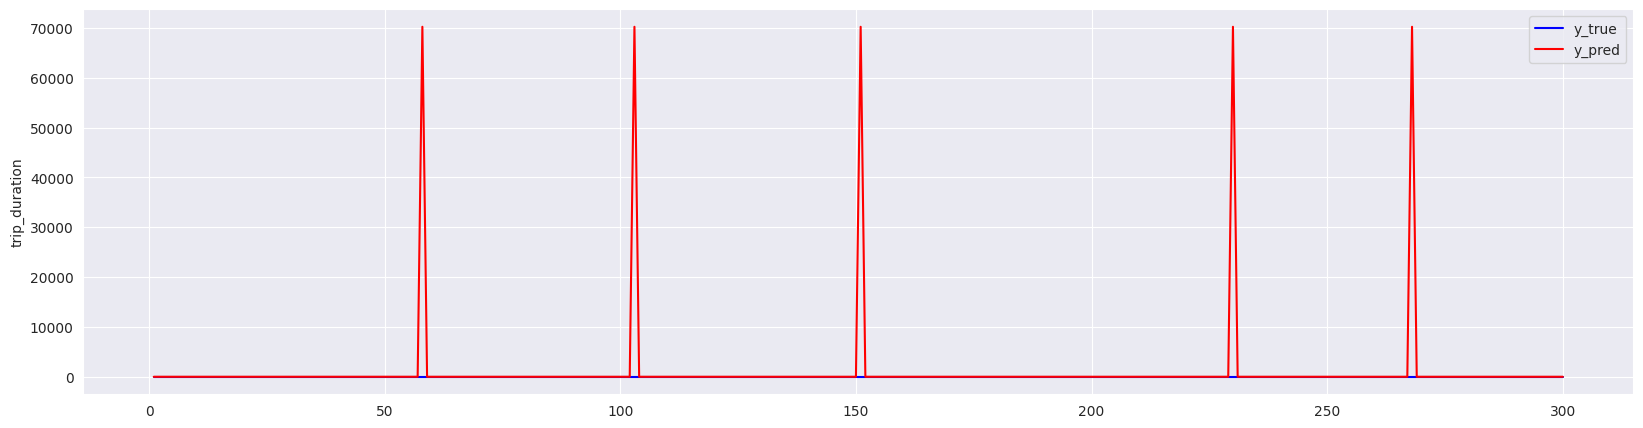

In [ ]:
y_test_for_plot = y_test[:300]
y_test_pred_for_plot = y_test_pred[:300]
n = len(y_test_for_plot)

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x=np.linspace(1, n, n), y=y_test_for_plot, color='b', label='y_true')
ax = sns.lineplot(x=np.linspace(1, n, n), y=y_test_pred_for_plot, color='r', label='y_pred')

#### With map

In [ ]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import folium

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
corr_log_distance = df_train['log_trip_duration'].corr(df_train['log_distance'])
corr_distance = df_train['log_trip_duration'].corr(df_train['distance'])
print(f'corr_log_distance = {corr_log_distance}')
print(f'corr_distance = {corr_distance}')

corr_log_distance = 0.781969163556191
corr_distance = 0.6506638765029144


#### Answer

In [ ]:
df_ans = pd.DataFrame({
    'id' : df_submission['id'],
    'trip_duration' : y_test_pred
})
df_ans.to_csv('data_ans.csv', index=False)